In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Input, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

2024-03-11 08:50:19.918820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load CSV data
csv_file = "/media/kanjibrian/Transcend7/concat/concatenated_file.csv"
df_csv = pd.read_csv(csv_file)

In [3]:
# Function to load and preprocess images
def load_and_preprocess_images(image_ids, image_folder):
    images = []
    for image_id in image_ids:
        image_path = f"{image_folder}/{image_id}"  # Change the extension if images are not in JPG format
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Resize to VGG16 input size
        img = np.array(img)
        #remove extra channels
        if img.shape[2] > 3:
            img=img[:,:,:3]
        img = img.astype('float32') / 255.0  # Normalize between 0 and 1
        img = preprocess_input(img)  # Preprocess for VGG16
        images.append(img)
    return np.array(images)

# Load and preprocess images
image_folder = "/media/kanjibrian/Transcend7/testing"
image_ids = df_csv['image_id'].values
image_data = load_and_preprocess_images(image_ids, image_folder)

In [4]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
df_csv['Label'] = label_encoder.fit_transform(df_csv['Label'])

# Split data into features (X) and labels (y)
X_images = image_data
X_features = df_csv[['Temperature', 'Humidity']].values
y = to_categorical(df_csv['Label'])

# Split data into training and validation sets
X_train_img, X_val_img, X_train_feat, X_val_feat, y_train, y_val = train_test_split(X_images, X_features, y, test_size=0.3, random_state=42)

In [5]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for the image data
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# Create an input layer for the features
input_features = Input(shape=(2,))
x_feat = Dense(128, activation='relu')(input_features)
x_feat= Dense(64, activation='relu')(x_feat)

# Concatenate image features and CSV features
concatenated=concatenate([x, x_feat])

# Final output layer
predictions = Dense(len(label_encoder.classes_), activation='softmax')(concatenated)

# Create the final model
model = Model(inputs=[base_model.input, input_features], outputs=predictions)

2024-03-11 08:52:01.321770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 08:52:01.326840: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit([X_train_img, X_train_feat], y_train, epochs=50, batch_size=32, validation_data=([X_val_img, X_val_feat], y_val), callbacks=[early_stopping])

Epoch 1/50
58/58 [==============================] - 1020s 18s/step - loss: 2.2086 - accuracy: 0.3705 - val_loss: 1.1168 - val_accuracy: 0.3916
Epoch 2/50
58/58 [==============================] - 831s 14s/step - loss: 1.0106 - accuracy: 0.4902 - val_loss: 1.1663 - val_accuracy: 0.3815
Epoch 3/50
58/58 [==============================] - 761s 13s/step - loss: 1.0130 - accuracy: 0.5103 - val_loss: 0.9648 - val_accuracy: 0.4626
Epoch 4/50
58/58 [==============================] - 747s 13s/step - loss: 0.8634 - accuracy: 0.5974 - val_loss: 0.8131 - val_accuracy: 0.7123
Epoch 5/50
58/58 [==============================] - 749s 13s/step - loss: 0.7899 - accuracy: 0.6725 - val_loss: 0.7306 - val_accuracy: 0.7098
Epoch 6/50
58/58 [==============================] - 744s 13s/step - loss: 0.7741 - accuracy: 0.6687 - val_loss: 0.7782 - val_accuracy: 0.7085
Epoch 7/50
58/58 [==============================] - 745s 13s/step - loss: 0.6636 - accuracy: 0.7628 - val_loss: 0.6841 - val_accuracy: 0.7414
Epoch

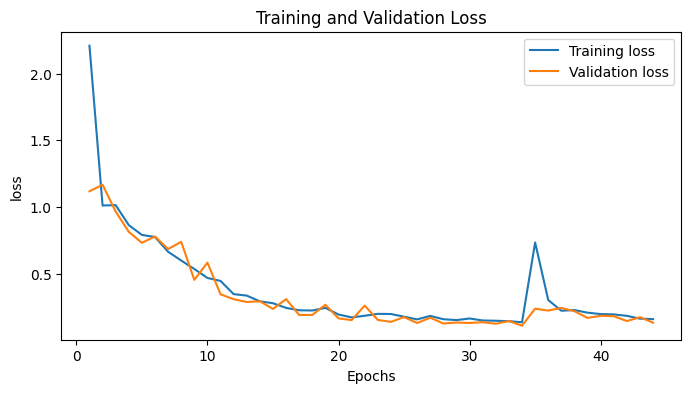

In [7]:
#plotting the training and validation loss
import matplotlib.pyplot as plt

#extracting loss and validation loss from the history object
train_loss=history.history['loss']
val_loss=history.history['val_loss']

#create a range for the number of epochs
epochs=range(1,len(train_loss)+1)
#plotting training and validation loss
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss,label='Training loss')
plt.plot(epochs,val_loss,label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
#Evaluate the model
y_pred=model.predict([X_val_img,X_val_feat])
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)

25/25 [==============================] - 314s 13s/step


In [9]:
#get class labels
class_labels=label_encoder.classes_

In [10]:
#calculate the metrics
accuracy=accuracy_score(y_true, y_pred_classes)
f1=f1_score(y_true,y_pred_classes,average='weighted')
cm=confusion_matrix(y_true,y_pred_classes,labels=np.arange(len(class_labels)))

#print the metrics
print("Accuracy: ", accuracy)
print("F1-Score: ", f1)
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=class_labels,columns=class_labels))

Accuracy:  0.9721166032953105
F1-Score:  0.9721166032953105
Confusion Matrix:
            aggression  calling  courtship
aggression         181        0         11
calling              0      303          0
courtship           11        0        283
